<a href="https://colab.research.google.com/github/tolom131/Human-Activity-Recognition/blob/main/Tensorflow/transformer_autoencoder_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from __future__ import print_function
from matplotlib import pyplot as plt
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import mean_squared_error, confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, LSTM, Conv1D, Activation, MaxPooling1D, UpSampling1D, concatenate

from tensorflow.keras import layers

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import initializers
from tensorflow.keras import backend as K

import random as rn
from resource import *
import time
import math
import sys
from collections import Counter

In [2]:
from google.colab import drive 
drive.mount('/content/drive/', force_remount=True)

directory_data  = './drive/MyDrive/HAR/'
filename_data   = 'WISDM_at_v2.0_raw.txt'
 
sys.path.append('/content/drive/MyDrive/HAR/')
import wisdm_1_1
import wisdm_2_0
# x_train, y_train, num_classes = wisdm_1_1.create_wisdm_1_1(directory_data + filename_data)
original_x, original_y, num_classes = wisdm_2_0.create_wisdm_2_0(directory_data + filename_data)

Mounted at /content/drive/


/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


x_train.shape :  (13913, 200, 3) y_train.shape:  (13913, 6)


In [13]:
def ConvolutionalBlock(dim_shape, filters=128, is_encoder=True):
    initializer = initializers.GlorotNormal()

    # is_encoder : "encoder" means that layers is part of encoder, else part of decoder
    if is_encoder:
        out_filter = filters * 2
    else:
        out_filters = int(filters / 2)

    inputs = Input(shape=dim_shape)
    x = Conv1D(filters=filters, kernel_size=3, padding="same", kernel_initializer=initializer)(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    if is_encoder:
        x = Conv1D(filters=filters * 2, kernel_size=3, strides=2, padding="same", kernel_initializer=initializer)(x)
        outputs = Activation("relu")(x)
    else:
        x = Conv1D(filters=filters // 2, kernel_size=3, strides=1, padding="same", kernel_initializer=initializer)(x)
        x = Activation("relu")(x)
        outputs = UpSampling1D()(x)

    model = Model(inputs, outputs)
    return model

def MultiheadBlock(dim_shape, filters=128):
    initializer = initializers.GlorotNormal()

    inputs = keras.Input(shape=dim_shape)
    x = layers.MultiHeadAttention(key_dim=512, num_heads=8)(inputs, inputs)
    x = x + inputs
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    x = Conv1D(filters, kernel_size=3, padding="same", kernel_initializer=initializer)(x)
    outputs = Activation("relu")(x)

    model = Model(inputs, outputs)
    return model

def Transformer_Autoencoder(x_train, y_train, x_val, y_val, alpha=0.1):

    ########################################################################
    # functions
    ########################################################################
    earlystop = EarlyStopping(patience=100, monitor='val_loss', mode='min', restore_best_weights=True)
    callbacks_list = [earlystop]
    initializer = initializers.GlorotNormal()
    adam = Adam(learning_rate=0.01)

    ########################################################################
    # encoder
    ########################################################################
    inputs = Input(shape=(200, 3))
    x = ConvolutionalBlock((200, 3), filters=64, is_encoder=True)(inputs)
    x = MultiheadBlock((100, 128), 128)(x)
    x = ConvolutionalBlock((100, 128), filters=128, is_encoder=True)(x)
    x = MultiheadBlock((50, 256), 256)(x)
    encoded = ConvolutionalBlock((50, 256), filters=256, is_encoder=True)(x)

    ########################################################################
    # decoder
    ######################################################################## 
    x = ConvolutionalBlock((25, 512), 512, is_encoder=False)(encoded)
    x = MultiheadBlock((50, 256), 256)(x)
    x = ConvolutionalBlock((50, 256), filters=256, is_encoder=False)(x)
    x = MultiheadBlock((100, 128), 128)(x)
    x = ConvolutionalBlock((100, 128), filters=128, is_encoder=False)(x)
    decoded = Conv1D(3, kernel_size=3, padding="same", name="decoded", kernel_initializer=initializer)(x)

    ########################################################################
    # classifier
    ########################################################################
    x = Conv1D(filters=64, kernel_size=3, input_shape=(25, 512), kernel_initializer=initializer)(encoded)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Conv1D(filters=128, kernel_size=3, kernel_initializer=initializer)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = LSTM(128, kernel_initializer=initializer)(x)
    classified = Dense(num_classes, activation="softmax", name="classified", kernel_initializer=initializer)(x)

    ########################################################################
    # model
    ########################################################################
    model = Model(inputs=inputs, outputs=decoded)
    model.compile(optimizer=adam, loss="mse", metrics=["accuracy"])
    history = model.fit(x_train, x_train, validation_data = (x_val, x_val), batch_size = 128, epochs=200, verbose=1, callbacks = callbacks_list)

    return history, model

In [14]:
# 80%, 10%, 10%로 set 나누기
x_train, x_val, y_train, y_val = train_test_split(original_x, original_y, test_size=0.2, stratify=original_y)
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, stratify=y_val)

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
# history, model = Transformer_Autoencoder(x_train_noisy, y_train, x_val, y_val)
model = Transformer_Autoencoder(x_train_noisy, y_train, x_val, y_val)

Epoch 1/200
87/87 [==============================] - 31s 296ms/step - loss: 0.4372 - accuracy: 0.3647 - val_loss: 0.0867 - val_accuracy: 0.4458
Epoch 2/200
87/87 [==============================] - 25s 287ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0867 - val_accuracy: 0.4458
Epoch 3/200
87/87 [==============================] - 25s 286ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0867 - val_accuracy: 0.4458
Epoch 4/200
87/87 [==============================] - 25s 287ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0867 - val_accuracy: 0.4458
Epoch 5/200
87/87 [==============================] - 25s 288ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0866 - val_accuracy: 0.4458
Epoch 6/200
87/87 [==============================] - 25s 288ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0866 - val_accuracy: 0.4458
Epoch 7/200
87/87 [==============================] - 25s 287ms/step - loss: 0.3355 - accuracy: 0.4077 - val_loss: 0.0866 - val_accuracy:

KeyboardInterrupt: ignored

In [12]:
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 200, 3)]          0         
                                                                 
 model_7 (Functional)        (None, 100, 128)          25600     
                                                                 
 model_8 (Functional)        (None, 100, 128)          2159360   
                                                                 
 model_9 (Functional)        (None, 50, 256)           148352    
                                                                 
 model_10 (Functional)       (None, 50, 256)           4404736   
                                                                 
 model_11 (Functional)       (None, 25, 512)           591616    
                                                                 
 model_12 (Functional)       (None, 50, 256)           118

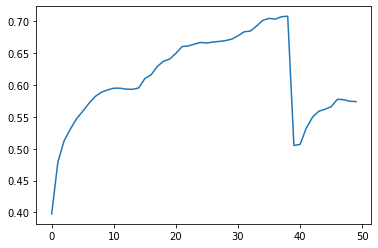

In [6]:
plt.plot(np.arange(50), history.history["accuracy"])

In [5]:
test_results = model.evaluate(x_test, y_test)

print("maximum train acc : ", max(history.history["accuracy"]))
print("maximum valid acc : ", max(history.history["val_accuracy"]))
print("test acc : ", test_results[1])
print("test loss : ", test_results[0])


y_pred = model.predict([x_test])
score = f1_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average="macro")
print("f1 score : ", score)
matrix = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print(matrix)

label = ["Jogging", "LyingDown", "Sitting", "Stairs", "Stading", "Walking"]
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(matrix, interpolation="nearest")
fig.colorbar(cax)
ax.set_xticklabels(['']+label)
ax.set_yticklabels(['']+label)
plt.show()

ValueError: ignored